# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [var_smoothing](#var_smoothing)
* [Discussion](#Discussion)

# Introduction

After rounds of feature engineering, visualization & exploration, and tuning various aspects of the classification pipeline, we are about to create a prototype classifier using a bagged GaussianNB. In this notebook, we perform grid searches over var_smoothing using out-of-bag accuracy instead of cross validation.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd
from scipy.stats import loguniform

# utility
from copy import deepcopy
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

# metrics
from sklearn.metrics import log_loss, roc_auc_score

# typing
from typing import Sequence

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.08 s


In [4]:
# Location of pre-final labels and features
FEATURES_FOLDER = (
    "../24.0-mic-train_new_prototypes_with_simplified_pipeline_and_no_song_data"
)

# Location where this notebook will output
DATA_OUT_FOLDER = "./tune_GNB"

_ = gc_collect()

time: 124 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    return pd.read_feather(f"{FEATURES_FOLDER}/simplified_labels.feather").set_index(
        "id"
    )


def load_data() -> pd.DataFrame:
    """Loads the FRILL-based features"""
    df = pd.read_feather("./scaled_features_ready_for_selection.feather").set_index(
        "id"
    )
    df.columns = df.columns.astype(str)
    return df


data = load_data()
labels = load_labels()
assert all(data.index == labels.index)
assert len(data) < 86000
y_true = labels.valence
_ = gc_collect()

time: 233 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 85740 entries, 0 to 87363
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     85740 non-null  float64
 1   LDA2                     85740 non-null  float64
 2   ocSVM_sgdlinear_neg      85740 non-null  float64
 3   ocSVM_sgdlinear_neu      85740 non-null  float64
 4   ocSVM_sgdlinear_pos      85740 non-null  float64
 5   LDA-LOF_neg_20           85740 non-null  float64
 6   LDA-LOF_neu_20           85740 non-null  float64
 7   LDA-LOF_pos_20           85740 non-null  float64
 8   LDA-ocSVM_rbf_neg        85740 non-null  float64
 9   LDA-ocSVM_rbf_neu        85740 non-null  float64
 10  LDA-ocSVM_rbf_pos        85740 non-null  float64
 11  LDA-ocSVM_sgdlinear_neg  85740 non-null  float64
 12  LDA-ocSVM_sgdlinear_neu  85740 non-null  float64
 13  LDA-ocSVM_sgdlinear_pos  85740 non-null  float64
dtypes: float64(14)
memory

In [7]:
results = {"var_smoothing": [], "oob_score": [], "log_loss": [], "auroc": []}
_ = gc_collect()

time: 95.1 ms


# var_smoothing

In [8]:
def tune_var_smoothing(search_space: Sequence, outfile: str) -> None:
    """Run tuning procedure"""
    df = deepcopy(data)
    make_gnb = lambda var_smoothing: BaggingClassifier(
        base_estimator=GaussianNB(var_smoothing=var_smoothing),
        n_estimators=50,
        oob_score=True,
        n_jobs=-1,
        random_state=SEED,
        # verbose=1,
    ).fit(df, y_true)
    for hp in tqdm(search_space):
        gnb = make_gnb(hp)
        results["var_smoothing"].append(hp)
        results["oob_score"].append(gnb.oob_score_)
        results["auroc"].append(
            roc_auc_score(y_true, y_pred := gnb.predict_proba(df), multi_class="ovo")
        )
        results["log_loss"].append(log_loss(y_true, y_pred))

    df = pd.DataFrame(results).sort_values(by="var_smoothing", ascending=True)
    print(df.sort_values(by="oob_score", ascending=False).head(10))
    print(df.sort_values(by="log_loss", ascending=True).head(10))
    print(df.sort_values(by="auroc", ascending=False).head(10))
    df.plot(x="var_smoothing")
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

    df.columns = df.columns.astype(str)
    df.reset_index(drop=True).to_feather(f"{DATA_OUT_FOLDER}/{outfile}.feather")
    del df


_ = gc_collect()

time: 119 ms


  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
0        0.002808   0.679624  1.213260  0.829300
24       0.005599   0.677723  1.111362  0.828572
33       0.011346   0.670294  1.004468  0.827150
41       0.012735   0.668008  0.989536  0.826827
3        0.014992   0.664486  0.970598  0.826321
48       0.024178   0.649429  0.933057  0.824489
40       0.024416   0.649172  0.932580  0.824446
19       0.028930   0.642757  0.926156  0.823670
2        0.034015   0.635386  0.923006  0.822879
28       0.063658   0.599767  0.930024  0.819613
    var_smoothing  oob_score  log_loss     auroc
2        0.034015   0.635386  0.923006  0.822879
19       0.028930   0.642757  0.926156  0.823670
28       0.063658   0.599767  0.930024  0.819613
40       0.024416   0.649172  0.932580  0.824446
48       0.024178   0.649429  0.933057  0.824489
21       0.087750   0.584558  0.939001  0.818050
42       0.089039   0.583940  0.939411  0.817985
22       0.089603   0.583742  0.939587  0.817957
16       0.101853   

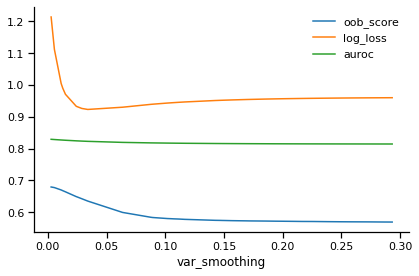

time: 3min 28s


In [9]:
tune_var_smoothing(
    search_space=np.random.uniform(0.0, 0.3, size=50), outfile="var_smoothing1"
)

  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
75   8.170631e-05   0.679823  1.384084  0.829990
86   4.381361e-05   0.679741  1.387261  0.829999
88   4.324212e-05   0.679741  1.387309  0.829999
96   1.898003e-04   0.679706  1.375182  0.829964
65   2.485592e-05   0.679694  1.388861  0.830003
57   1.219385e-11   0.679683  1.390969  0.830009
54   1.498979e-09   0.679683  1.390969  0.830009
62   2.462678e-04   0.679683  1.370621  0.829950
84   1.222535e-11   0.679683  1.390969  0.830009
72   1.803619e-07   0.679683  1.390954  0.830009
    var_smoothing  oob_score  log_loss     auroc
2        0.034015   0.635386  0.923006  0.822879
59       0.030153   0.640914  0.925086  0.823472
19       0.028930   0.642757  0.926156  0.823670
28       0.063658   0.599767  0.930024  0.819613
40       0.024416   0.649172  0.932580  0.824446
48       0.024178   0.649429  0.933057  0.824489
74       0.023798   0.650105  0.933853  0.824559
56       0.077205   0.589935  0.935354  0.818653
21       0.087750   

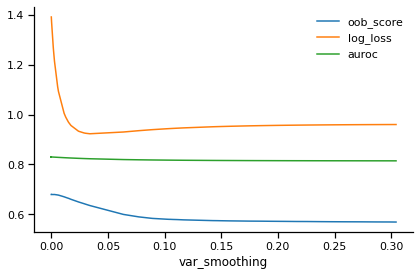

time: 3min 22s


In [10]:
tune_var_smoothing(
    search_space=loguniform.rvs(1e-11, 0.4, size=50), outfile="var_smoothing2"
)

  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
75   8.170631e-05   0.679823  1.384084  0.829990
86   4.381361e-05   0.679741  1.387261  0.829999
88   4.324212e-05   0.679741  1.387309  0.829999
96   1.898003e-04   0.679706  1.375182  0.829964
65   2.485592e-05   0.679694  1.388861  0.830003
57   1.219385e-11   0.679683  1.390969  0.830009
60   1.462300e-09   0.679683  1.390969  0.830009
62   2.462678e-04   0.679683  1.370621  0.829950
58   1.895164e-07   0.679683  1.390953  0.830009
72   1.803619e-07   0.679683  1.390954  0.830009
    var_smoothing  oob_score  log_loss     auroc
2        0.034015   0.635386  0.923006  0.822879
59       0.030153   0.640914  0.925086  0.823472
19       0.028930   0.642757  0.926156  0.823670
28       0.063658   0.599767  0.930024  0.819613
40       0.024416   0.649172  0.932580  0.824446
48       0.024178   0.649429  0.933057  0.824489
74       0.023798   0.650105  0.933853  0.824559
56       0.077205   0.589935  0.935354  0.818653
21       0.087750   

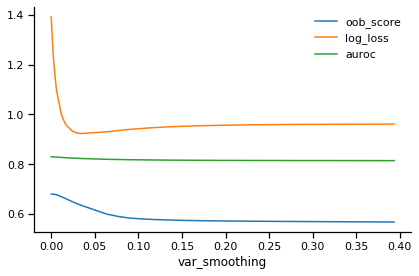

time: 3min 19s


In [11]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.1, 0.4, size=50), outfile="var_smoothing3"
)

  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
75   8.170631e-05   0.679823  1.384084  0.829990
86   4.381361e-05   0.679741  1.387261  0.829999
88   4.324212e-05   0.679741  1.387309  0.829999
96   1.898003e-04   0.679706  1.375182  0.829964
65   2.485592e-05   0.679694  1.388861  0.830003
57   1.219385e-11   0.679683  1.390969  0.830009
54   1.498979e-09   0.679683  1.390969  0.830009
62   2.462678e-04   0.679683  1.370621  0.829950
84   1.222535e-11   0.679683  1.390969  0.830009
72   1.803619e-07   0.679683  1.390954  0.830009
     var_smoothing  oob_score  log_loss     auroc
163       0.035371   0.632669  0.922641  0.822682
153       0.034744   0.633730  0.922790  0.822773
194       0.034717   0.633812  0.922797  0.822777
2         0.034015   0.635386  0.923006  0.822879
152       0.033137   0.636844  0.923334  0.823009
199       0.032932   0.637252  0.923423  0.823041
59        0.030153   0.640914  0.925086  0.823472
166       0.029262   0.642174  0.925843  0.823616
187       0

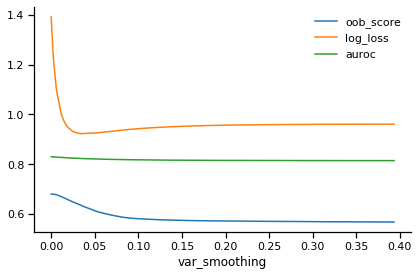

time: 3min 12s


In [12]:
tune_var_smoothing(
    search_space=np.random.uniform(0.01, 0.25, size=50), outfile="var_smoothing4"
)

  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
75   8.170631e-05   0.679823  1.384084  0.829990
88   4.324212e-05   0.679741  1.387309  0.829999
86   4.381361e-05   0.679741  1.387261  0.829999
96   1.898003e-04   0.679706  1.375182  0.829964
65   2.485592e-05   0.679694  1.388861  0.830003
54   1.498979e-09   0.679683  1.390969  0.830009
62   2.462678e-04   0.679683  1.370621  0.829950
84   1.222535e-11   0.679683  1.390969  0.830009
58   1.895164e-07   0.679683  1.390953  0.830009
72   1.803619e-07   0.679683  1.390954  0.830009
     var_smoothing  oob_score  log_loss     auroc
163       0.035371   0.632669  0.922641  0.822682
153       0.034744   0.633730  0.922790  0.822773
194       0.034717   0.633812  0.922797  0.822777
2         0.034015   0.635386  0.923006  0.822879
152       0.033137   0.636844  0.923334  0.823009
199       0.032932   0.637252  0.923423  0.823041
59        0.030153   0.640914  0.925086  0.823472
166       0.029262   0.642174  0.925843  0.823616
187       0

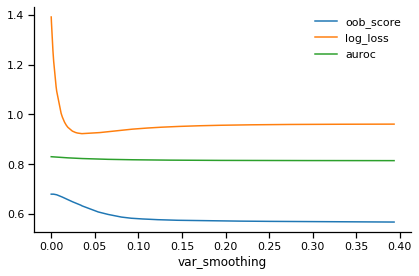

time: 3min 21s


In [13]:
tune_var_smoothing(
    search_space=np.random.uniform(0.05, 0.15, size=50), outfile="var_smoothing5"
)

  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
75   8.170631e-05   0.679823  1.384084  0.829990
86   4.381361e-05   0.679741  1.387261  0.829999
88   4.324212e-05   0.679741  1.387309  0.829999
96   1.898003e-04   0.679706  1.375182  0.829964
65   2.485592e-05   0.679694  1.388861  0.830003
57   1.219385e-11   0.679683  1.390969  0.830009
60   1.462300e-09   0.679683  1.390969  0.830009
62   2.462678e-04   0.679683  1.370621  0.829950
58   1.895164e-07   0.679683  1.390953  0.830009
72   1.803619e-07   0.679683  1.390954  0.830009
     var_smoothing  oob_score  log_loss     auroc
293       0.037646   0.629624  0.922346  0.822365
262       0.040724   0.625659  0.922454  0.821958
267       0.036216   0.631514  0.922488  0.822563
163       0.035371   0.632669  0.922641  0.822682
153       0.034744   0.633730  0.922790  0.822773
194       0.034717   0.633812  0.922797  0.822777
261       0.034606   0.633905  0.922827  0.822793
2         0.034015   0.635386  0.923006  0.822879
258       0

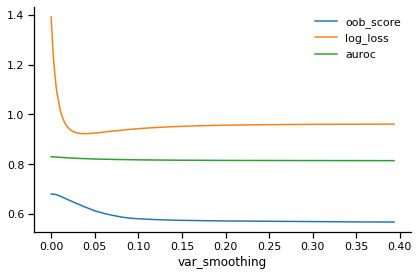

time: 3min 19s


In [14]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.01, 0.25, size=50), outfile="var_smoothing6"
)

  0%|          | 0/15 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
75   8.170631e-05   0.679823  1.384084  0.829990
86   4.381361e-05   0.679741  1.387261  0.829999
88   4.324212e-05   0.679741  1.387309  0.829999
96   1.898003e-04   0.679706  1.375182  0.829964
65   2.485592e-05   0.679694  1.388861  0.830003
57   1.219385e-11   0.679683  1.390969  0.830009
60   1.462300e-09   0.679683  1.390969  0.830009
84   1.222535e-11   0.679683  1.390969  0.830009
58   1.895164e-07   0.679683  1.390953  0.830009
72   1.803619e-07   0.679683  1.390954  0.830009
     var_smoothing  oob_score  log_loss     auroc
293       0.037646   0.629624  0.922346  0.822365
262       0.040724   0.625659  0.922454  0.821958
267       0.036216   0.631514  0.922488  0.822563
163       0.035371   0.632669  0.922641  0.822682
153       0.034744   0.633730  0.922790  0.822773
194       0.034717   0.633812  0.922797  0.822777
261       0.034606   0.633905  0.922827  0.822793
2         0.034015   0.635386  0.923006  0.822879
258       0

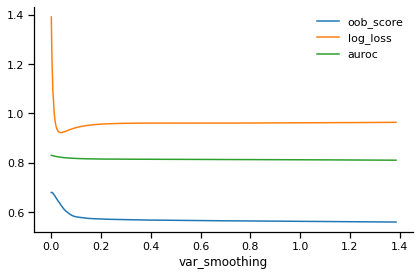

  0%|          | 0/15 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
75   8.170631e-05   0.679823  1.384084  0.829990
86   4.381361e-05   0.679741  1.387261  0.829999
88   4.324212e-05   0.679741  1.387309  0.829999
96   1.898003e-04   0.679706  1.375182  0.829964
65   2.485592e-05   0.679694  1.388861  0.830003
57   1.219385e-11   0.679683  1.390969  0.830009
54   1.498979e-09   0.679683  1.390969  0.830009
62   2.462678e-04   0.679683  1.370621  0.829950
58   1.895164e-07   0.679683  1.390953  0.830009
72   1.803619e-07   0.679683  1.390954  0.830009
     var_smoothing  oob_score  log_loss     auroc
293       0.037646   0.629624  0.922346  0.822365
262       0.040724   0.625659  0.922454  0.821958
267       0.036216   0.631514  0.922488  0.822563
163       0.035371   0.632669  0.922641  0.822682
153       0.034744   0.633730  0.922790  0.822773
194       0.034717   0.633812  0.922797  0.822777
261       0.034606   0.633905  0.922827  0.822793
2         0.034015   0.635386  0.923006  0.822879
258       0

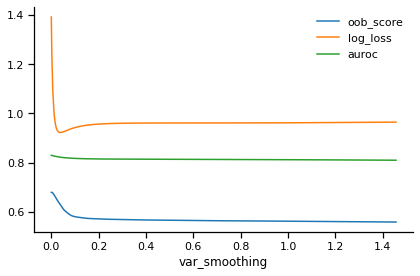

time: 2min 1s


In [15]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.01, 1.5, size=15), outfile="var_smoothing7"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.01, 1.5, size=15), outfile="var_smoothing8"
)

  0%|          | 0/11 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
75   8.170631e-05   0.679823  1.384084  0.829990
86   4.381361e-05   0.679741  1.387261  0.829999
88   4.324212e-05   0.679741  1.387309  0.829999
96   1.898003e-04   0.679706  1.375182  0.829964
65   2.485592e-05   0.679694  1.388861  0.830003
57   1.219385e-11   0.679683  1.390969  0.830009
60   1.462300e-09   0.679683  1.390969  0.830009
62   2.462678e-04   0.679683  1.370621  0.829950
58   1.895164e-07   0.679683  1.390953  0.830009
72   1.803619e-07   0.679683  1.390954  0.830009
     var_smoothing  oob_score  log_loss     auroc
293       0.037646   0.629624  0.922346  0.822365
262       0.040724   0.625659  0.922454  0.821958
267       0.036216   0.631514  0.922488  0.822563
163       0.035371   0.632669  0.922641  0.822682
153       0.034744   0.633730  0.922790  0.822773
194       0.034717   0.633812  0.922797  0.822777
261       0.034606   0.633905  0.922827  0.822793
2         0.034015   0.635386  0.923006  0.822879
258       0

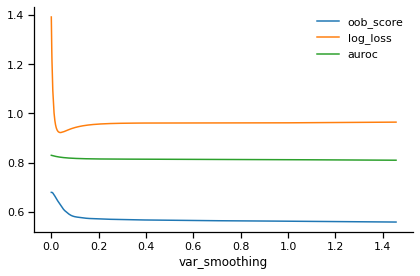

  0%|          | 0/11 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
75   8.170631e-05   0.679823  1.384084  0.829990
86   4.381361e-05   0.679741  1.387261  0.829999
88   4.324212e-05   0.679741  1.387309  0.829999
96   1.898003e-04   0.679706  1.375182  0.829964
65   2.485592e-05   0.679694  1.388861  0.830003
57   1.219385e-11   0.679683  1.390969  0.830009
54   1.498979e-09   0.679683  1.390969  0.830009
62   2.462678e-04   0.679683  1.370621  0.829950
58   1.895164e-07   0.679683  1.390953  0.830009
72   1.803619e-07   0.679683  1.390954  0.830009
     var_smoothing  oob_score  log_loss     auroc
293       0.037646   0.629624  0.922346  0.822365
262       0.040724   0.625659  0.922454  0.821958
267       0.036216   0.631514  0.922488  0.822563
163       0.035371   0.632669  0.922641  0.822682
153       0.034744   0.633730  0.922790  0.822773
194       0.034717   0.633812  0.922797  0.822777
261       0.034606   0.633905  0.922827  0.822793
2         0.034015   0.635386  0.923006  0.822879
258       0

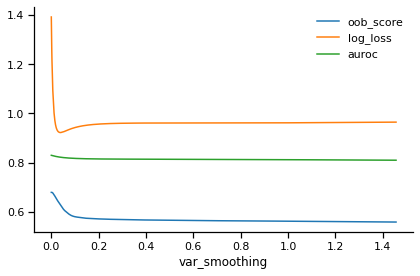

time: 1min 25s


In [16]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.12, 0.17, size=11), outfile="var_smoothing9"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.12, 0.17, size=11), outfile="var_smoothing10"
)

  0%|          | 0/13 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
75   8.170631e-05   0.679823  1.384084  0.829990
86   4.381361e-05   0.679741  1.387261  0.829999
88   4.324212e-05   0.679741  1.387309  0.829999
96   1.898003e-04   0.679706  1.375182  0.829964
65   2.485592e-05   0.679694  1.388861  0.830003
57   1.219385e-11   0.679683  1.390969  0.830009
54   1.498979e-09   0.679683  1.390969  0.830009
62   2.462678e-04   0.679683  1.370621  0.829950
58   1.895164e-07   0.679683  1.390953  0.830009
72   1.803619e-07   0.679683  1.390954  0.830009
     var_smoothing  oob_score  log_loss     auroc
293       0.037646   0.629624  0.922346  0.822365
262       0.040724   0.625659  0.922454  0.821958
267       0.036216   0.631514  0.922488  0.822563
163       0.035371   0.632669  0.922641  0.822682
153       0.034744   0.633730  0.922790  0.822773
194       0.034717   0.633812  0.922797  0.822777
261       0.034606   0.633905  0.922827  0.822793
2         0.034015   0.635386  0.923006  0.822879
258       0

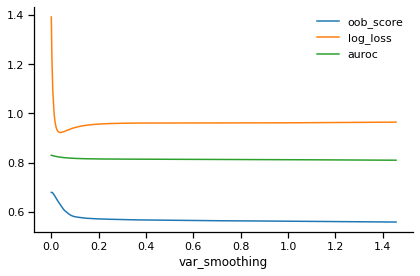

  0%|          | 0/13 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
75   8.170631e-05   0.679823  1.384084  0.829990
86   4.381361e-05   0.679741  1.387261  0.829999
88   4.324212e-05   0.679741  1.387309  0.829999
96   1.898003e-04   0.679706  1.375182  0.829964
65   2.485592e-05   0.679694  1.388861  0.830003
57   1.219385e-11   0.679683  1.390969  0.830009
54   1.498979e-09   0.679683  1.390969  0.830009
62   2.462678e-04   0.679683  1.370621  0.829950
58   1.895164e-07   0.679683  1.390953  0.830009
72   1.803619e-07   0.679683  1.390954  0.830009
     var_smoothing  oob_score  log_loss     auroc
293       0.037646   0.629624  0.922346  0.822365
262       0.040724   0.625659  0.922454  0.821958
267       0.036216   0.631514  0.922488  0.822563
163       0.035371   0.632669  0.922641  0.822682
153       0.034744   0.633730  0.922790  0.822773
194       0.034717   0.633812  0.922797  0.822777
261       0.034606   0.633905  0.922827  0.822793
2         0.034015   0.635386  0.923006  0.822879
258       0

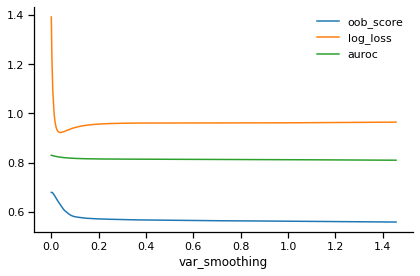

time: 1min 41s


In [17]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.2, 0.4, size=13), outfile="var_smoothing11"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.2, 0.2, size=13), outfile="var_smoothing12"
)

  0%|          | 0/30 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
407       0.000093   0.679846  1.383146  0.829987
75        0.000082   0.679823  1.384084  0.829990
396       0.000048   0.679776  1.386935  0.829998
394       0.000058   0.679764  1.386089  0.829995
86        0.000044   0.679741  1.387261  0.829999
88        0.000043   0.679741  1.387309  0.829999
399       0.000040   0.679729  1.387592  0.830000
96        0.000190   0.679706  1.375182  0.829964
404       0.000028   0.679694  1.388599  0.830003
65        0.000025   0.679694  1.388861  0.830003
     var_smoothing  oob_score  log_loss     auroc
293       0.037646   0.629624  0.922346  0.822365
262       0.040724   0.625659  0.922454  0.821958
267       0.036216   0.631514  0.922488  0.822563
163       0.035371   0.632669  0.922641  0.822682
153       0.034744   0.633730  0.922790  0.822773
194       0.034717   0.633812  0.922797  0.822777
261       0.034606   0.633905  0.922827  0.822793
2         0.034015   0.635386  0.923006  0.822879


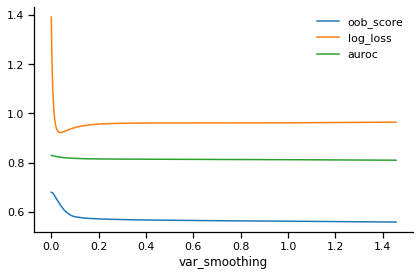

  0%|          | 0/30 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
407       0.000093   0.679846  1.383146  0.829987
75        0.000082   0.679823  1.384084  0.829990
396       0.000048   0.679776  1.386935  0.829998
394       0.000058   0.679764  1.386089  0.829995
86        0.000044   0.679741  1.387261  0.829999
88        0.000043   0.679741  1.387309  0.829999
399       0.000040   0.679729  1.387592  0.830000
96        0.000190   0.679706  1.375182  0.829964
65        0.000025   0.679694  1.388861  0.830003
404       0.000028   0.679694  1.388599  0.830003
     var_smoothing  oob_score  log_loss     auroc
293       0.037646   0.629624  0.922346  0.822365
262       0.040724   0.625659  0.922454  0.821958
267       0.036216   0.631514  0.922488  0.822563
163       0.035371   0.632669  0.922641  0.822682
153       0.034744   0.633730  0.922790  0.822773
194       0.034717   0.633812  0.922797  0.822777
261       0.034606   0.633905  0.922827  0.822793
2         0.034015   0.635386  0.923006  0.822879


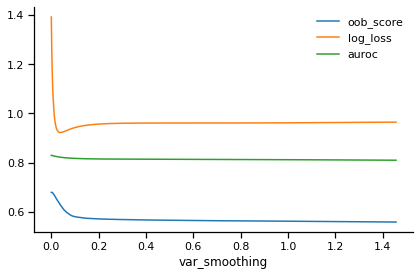

time: 3min 56s


In [18]:
tune_var_smoothing(
    search_space=loguniform.rvs(1e-12, 0.5, size=30), outfile="var_smoothing13"
)
tune_var_smoothing(
    search_space=np.random.uniform(1e-12, 0.5, size=30), outfile="var_smoothing14"
)

In [19]:
files = [
    "var_smoothing1.feather",
    "var_smoothing2.feather",
    "var_smoothing3.feather",
    "var_smoothing4.feather",
    "var_smoothing5.feather",
    "var_smoothing6.feather",
    "var_smoothing7.feather",
    "var_smoothing8.feather",
    "var_smoothing9.feather",
    "var_smoothing10.feather",
    "var_smoothing11.feather",
    "var_smoothing12.feather",
    "var_smoothing13.feather",
    "var_smoothing14.feather",
]
df = pd.concat(
    [pd.read_feather(f"{DATA_OUT_FOLDER}/{file}") for file in files],
    axis="rows",
)

time: 68 ms


<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

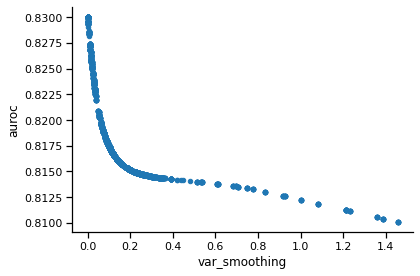

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

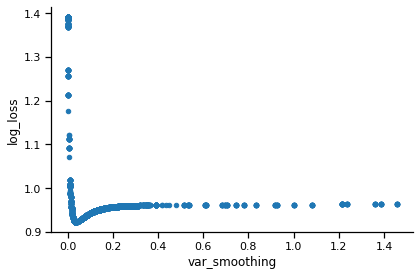

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

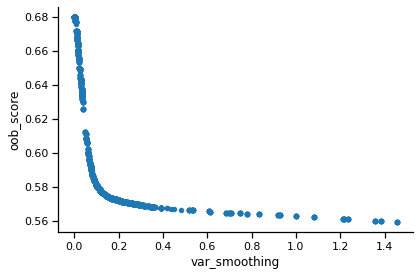

time: 842 ms


In [20]:
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    df.sort_values(by="var_smoothing").plot(x="var_smoothing", y=metric, kind="scatter")
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

In [21]:
# best
df = df.drop_duplicates()
df.loc[df.log_loss == df.log_loss.min()]
df.loc[df.oob_score == df.oob_score.max()].sort_values(by="log_loss", ascending=True)
df.loc[df.auroc == df.auroc.max()]

,var_smoothing,oob_score,log_loss,auroc
86,0.037646,0.629624,0.922346,0.822365


,var_smoothing,oob_score,log_loss,auroc
57,0.000093,0.679846,1.383146,0.829987


,var_smoothing,oob_score,log_loss,auroc
10,9.552534e-11,0.679683,1.390969,0.830009
11,1.050250e-10,0.679683,1.390969,0.830009


time: 55 ms


In [22]:
# next best
df.sort_values(by="log_loss", ascending=True).head(11).tail(10)
df.sort_values(by="oob_score", ascending=False).head(11).tail(10)
df.sort_values(by="auroc", ascending=False).head(11).tail(10)

,var_smoothing,oob_score,log_loss,auroc
87,0.040724,0.625659,0.922454,0.821958
85,0.036216,0.631514,0.922488,0.822563
61,0.035371,0.632669,0.922641,0.822682
60,0.034744,0.633730,0.922790,0.822773
59,0.034717,0.633812,0.922797,0.822777
81,0.034606,0.633905,0.922827,0.822793
8,0.034015,0.635386,0.923006,0.822879
79,0.033898,0.635596,0.923045,0.822896
81,0.033469,0.636156,0.923201,0.822960
57,0.033137,0.636844,0.923334,0.823009


,var_smoothing,oob_score,log_loss,auroc
33,0.000082,0.679823,1.384084,0.829990
54,0.000048,0.679776,1.386935,0.829998
55,0.000058,0.679764,1.386089,0.829995
32,0.000044,0.679741,1.387261,0.829999
31,0.000043,0.679741,1.387309,0.829999
51,0.000040,0.679729,1.387592,0.830000
34,0.000190,0.679706,1.375182,0.829964
50,0.000028,0.679694,1.388599,0.830003
30,0.000025,0.679694,1.388861,0.830003
48,0.000025,0.679694,1.388865,0.830003


,var_smoothing,oob_score,log_loss,auroc
10,9.552534e-11,0.679683,1.390969,0.830009
4,1.856188e-11,0.679683,1.390969,0.830009
3,1.701651e-11,0.679683,1.390969,0.830009
2,6.503296e-12,0.679683,1.390969,0.830009
3,7.763338e-12,0.679683,1.390969,0.830009
6,1.481363e-11,0.679683,1.390969,0.830009
0,1.219385e-11,0.679683,1.390969,0.830009
1,1.222535e-11,0.679683,1.390969,0.830009
2,1.619995e-11,0.679683,1.390969,0.830009
1,4.991682e-12,0.679683,1.390969,0.830009


time: 38 ms


In [23]:
df["diff"] = df.log_loss - df.oob_score
df.sort_values(by="diff", ascending=True).head(10)

,var_smoothing,oob_score,log_loss,auroc,diff
69,0.026744,0.645696,0.928714,0.824037,0.283018
68,0.024788,0.648705,0.931868,0.824379,0.283163
52,0.027849,0.644122,0.927310,0.823850,0.283188
71,0.028549,0.643282,0.926539,0.823733,0.283257
7,0.028930,0.642757,0.926156,0.823670,0.283399
6,0.024416,0.649172,0.932580,0.824446,0.283409
5,0.024178,0.649429,0.933057,0.824489,0.283628
54,0.029262,0.642174,0.925843,0.823616,0.283669
48,0.023798,0.650105,0.933853,0.824559,0.283748
52,0.030153,0.640914,0.925086,0.823472,0.284172


time: 18 ms


,var_smoothing,oob_score,log_loss,auroc,diff
86,0.037646,0.629624,0.922346,0.822365,0.292722


,var_smoothing,oob_score,log_loss,auroc,diff
10,9.552534e-11,0.679683,1.390969,0.830009,0.711287
11,1.050250e-10,0.679683,1.390969,0.830009,0.711287


<AxesSubplot:xlabel='var_smoothing'>

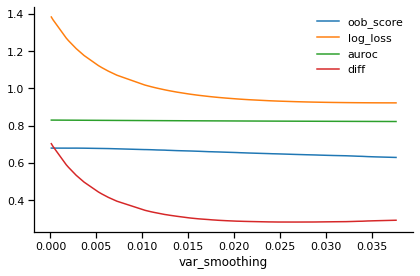

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

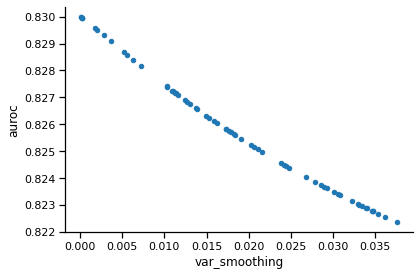

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

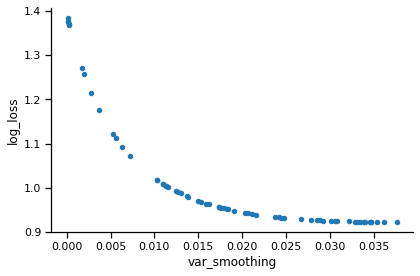

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

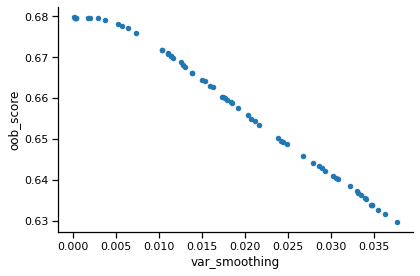

time: 977 ms


In [24]:
df.loc[df.log_loss == df.log_loss.min()]
df.loc[df.auroc == df.auroc.max()]

good_df = df.loc[df.var_smoothing < 0.15]
min_val = good_df.loc[good_df.oob_score == good_df.oob_score.max()].log_loss.min()
good_df = good_df.loc[good_df.log_loss <= min_val]
max_val = good_df.loc[good_df.log_loss == good_df.log_loss.min()].oob_score.max()
good_df = good_df.loc[good_df.oob_score >= max_val]

# plot
good_df.sort_values(by="var_smoothing").plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='var_smoothing'>

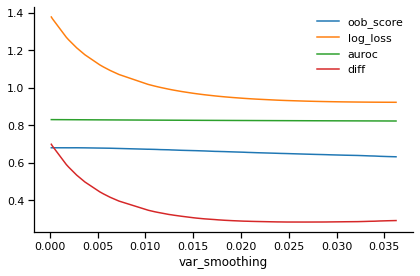

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

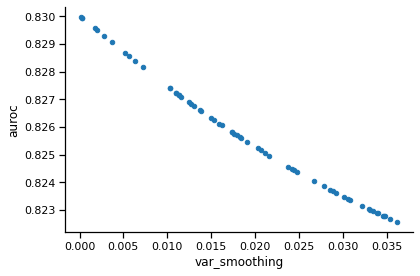

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

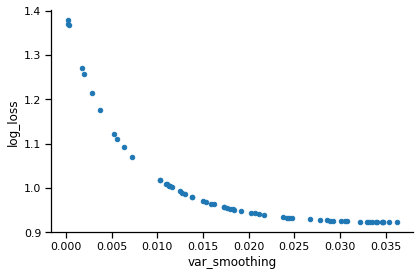

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

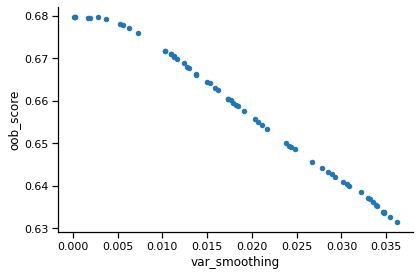

time: 1.25 s


In [25]:
good_df = good_df.loc[good_df.auroc < good_df.auroc.max()]
good_df = good_df.loc[good_df.oob_score < good_df.oob_score.max()]
good_df = good_df.loc[good_df.log_loss > good_df.log_loss.min()]

# plot
good_df.sort_values(by="var_smoothing").plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

In [26]:
# better bests
good_df.loc[good_df.log_loss == good_df.log_loss.min()]
good_df.loc[good_df.oob_score == good_df.oob_score.max()]
good_df.loc[good_df["diff"] == good_df["diff"].min()]

,var_smoothing,oob_score,log_loss,auroc,diff
85,0.036216,0.631514,0.922488,0.822563,0.290974


,var_smoothing,oob_score,log_loss,auroc,diff
35,0.000246,0.679683,1.370621,0.82995,0.690939


,var_smoothing,oob_score,log_loss,auroc,diff
69,0.026744,0.645696,0.928714,0.824037,0.283018


time: 33 ms


In [27]:
good_df.loc[good_df["diff"] == good_df["diff"].min()].var_smoothing.iloc[0]
_ = gc_collect()

0.026743984632167556

time: 3.96 ms


In [28]:
final_gnb = BaggingClassifier(
    base_estimator=GaussianNB(
        var_smoothing=good_df.loc[
            good_df["diff"] == good_df["diff"].min()
        ].var_smoothing.iloc[0]
    ),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
)
_ = gc_collect()

time: 126 ms


In [29]:
final_gnb.fit(data, labels.valence)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.1s remaining:   15.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished


BaggingClassifier(base_estimator=GaussianNB(var_smoothing=0.026743984632167556),
                  n_estimators=50, n_jobs=-1, oob_score=True, random_state=2022,
                  verbose=1)

time: 7.11 s


In [31]:
final_gnb.oob_score_
log_loss(y_true, final_gnb.predict_proba(data))
roc_auc_score(y_true, final_gnb.predict_proba(data), multi_class="ovo")

0.6456962911126662

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished


0.9287138566158194

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.9s remaining:    2.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.2s finished


0.8240365510111102

time: 3.13 s


# Discussion

There looks to be a sweet spot in training loss. We chose a balance between training log loss and OOB accuracy.

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [32]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 2321.156076192856 s
time: 157 ms


[^top](#Contents)